# Machine Learning Model Classification Gym Equipment

This notebook presents the machine learning model developed for the Capstone Project of the Bangkit Academy 2024 Batch 1. The model utilizes TensorFlow and various datasets to classifies gym equipment. It classifies images in 13 classes : 
1. cable_machine 
2. calfraise_machine 
3. chestfly_machine 
4. elliptical_trainer 
5. hacksquat_machine 
6. hyperextension_bench
7. latpulldown_machine
8. legcurl_machine
9. legpress_machine
10. rotarycalf_machine
11. rowing_machine
12. shoulder_press
13. smith_machine

This notebook execute using jupyter notebook in visual studio code. 

Using GPU for the accelerator during training with requirements:
- python 3.9.x 
- tensorflow 2.8.0
- CuDNN 8.1
- CUDA 11.2 

see the provision to use GPU:
https://www.tensorflow.org/install/source_windows?hl=id#gpu

The model build from pre-trained mobilenetv2

### Enable GPU

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Limit the memory growth

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


## Importing Libraries

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=2048)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
import tensorflow as tf
import os
import csv
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, GlobalAveragePooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import MobileNetV2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

## Data Preparation

### Importing Dataset and Define Classes

In [4]:
# Path to the dataset
dataset_path = 'D:/bangkit/mobilenet-tes/dataset'

# Category names
categories = ['cable_machine', 'calfraise_machine', 'chestfly_machine', 'elliptical_trainer', 'hacksquat_machine', 'hyperextension_bench', 'latpulldown_machine', 'legcurl_machine', 'legpress_machine', 'rotarycalf_machine', 'rowing_machine', 'shoulder_press', 'smith_machine']

# Output folder path   
output_path = 'D:/bangkit/mobilenet-tes/dataset_splitted'

### Splitting Dataset (train, val, test)

In [16]:
# Create output folders
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Create sub-folders for training, validation, and testing
for split in ['train', 'val', 'test']:
    split_path = os.path.join(output_path, split)
    if not os.path.exists(split_path):
        os.makedirs(split_path)
    for category in categories:
        category_path = os.path.join(split_path, category)
        if not os.path.exists(category_path):
            os.makedirs(category_path)

# Function to split the dataset
def split_dataset(category):
    category_path = os.path.join(dataset_path, category)
    images = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]

    train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    return train_images, val_images, test_images

# Move files to appropriate folders
def move_files(images, category, split):
    for image in images:
        src = os.path.join(dataset_path, category, image)
        dst = os.path.join(output_path, split, category, image)
        shutil.copy2(src, dst)

# Split the dataset and move files
for category in categories:
    train_images, val_images, test_images = split_dataset(category)
    move_files(train_images, category, 'train')
    move_files(val_images, category, 'val')
    move_files(test_images, category, 'test')

print("Dataset splitting finished.")

Dataset splitting finished.


## Modelling and Training Data



### Data Generators

In [5]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  #rescale array range to [-1, 1]
    rotation_range=10,  
    zoom_range=0.2,  
    horizontal_flip=True,  
    brightness_range=[0.7, 1.3], 
    shear_range=0.2,  
    fill_mode='nearest'
)



val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_dir = os.path.join(output_path, 'train')
val_dir = os.path.join(output_path, 'val')
test_dir = os.path.join(output_path, 'test')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False #category false, to make sure test data still ordered
)

Found 925 images belonging to 13 classes.
Found 194 images belonging to 13 classes.
Found 202 images belonging to 13 classes.


### Building the Model

In [6]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet') 

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Customn layer 
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu',  kernel_regularizer=l2(0.0001)), 
    Dropout(0.4),  
    BatchNormalization(),
    Dense(128, activation='relu',  kernel_regularizer=l2(0.0001)),
    Dropout(0.4),
    BatchNormalization(),
    Dense(13, activation='softmax')
])

optimizer = RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                        

### Training the Model --- use callbacks and early stop to avoid overfitting

In [7]:
# Allow PIL to load truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True


callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

history = model.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
    callbacks=callbacks
)

# Save the model
model.save('mobnet_banyak_kali_kontol8.h5')


Epoch 1/200
29/29 [==============================] - 31s 665ms/step - loss: 3.3150 - accuracy: 0.0752 - val_loss: 2.6315 - val_accuracy: 0.1031 - lr: 1.0000e-04
Epoch 2/200
29/29 [==============================] - 13s 431ms/step - loss: 3.0596 - accuracy: 0.1106 - val_loss: 2.5004 - val_accuracy: 0.1546 - lr: 1.0000e-04
Epoch 3/200
29/29 [==============================] - 13s 446ms/step - loss: 2.9571 - accuracy: 0.1206 - val_loss: 2.3745 - val_accuracy: 0.2113 - lr: 1.0000e-04
Epoch 4/200
29/29 [==============================] - 12s 431ms/step - loss: 2.7608 - accuracy: 0.1759 - val_loss: 2.2543 - val_accuracy: 0.2835 - lr: 1.0000e-04
Epoch 5/200
29/29 [==============================] - 13s 434ms/step - loss: 2.6994 - accuracy: 0.1681 - val_loss: 2.1398 - val_accuracy: 0.3196 - lr: 1.0000e-04
Epoch 6/200
29/29 [==============================] - 13s 448ms/step - loss: 2.5669 - accuracy: 0.1947 - val_loss: 2.0272 - val_accuracy: 0.3814 - lr: 1.0000e-04
Epoch 7/200
29/29 [===============

## Fine Tuning
### Enable few layer from mobilenetv2 to train

In [18]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(13, activation='softmax')
])


for layer in base_model.layers[-13:]:
    layer.trainable = True

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001),
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
]

history2 = model.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
    callbacks=callbacks
)

model.save('mobnet_fine_tuned_model12.h5')


Epoch 1/200
29/29 [==============================] - 23s 698ms/step - loss: 3.0965 - accuracy: 0.1124 - val_loss: 2.5813 - val_accuracy: 0.0928 - lr: 1.0000e-04
Epoch 2/200
29/29 [==============================] - 18s 638ms/step - loss: 2.8697 - accuracy: 0.1557 - val_loss: 2.3916 - val_accuracy: 0.2010 - lr: 1.0000e-04
Epoch 3/200
29/29 [==============================] - 19s 666ms/step - loss: 2.6089 - accuracy: 0.1827 - val_loss: 2.2444 - val_accuracy: 0.2990 - lr: 1.0000e-04
Epoch 4/200
29/29 [==============================] - 18s 625ms/step - loss: 2.4466 - accuracy: 0.2249 - val_loss: 2.0938 - val_accuracy: 0.3608 - lr: 1.0000e-04
Epoch 5/200
29/29 [==============================] - 19s 652ms/step - loss: 2.3063 - accuracy: 0.2692 - val_loss: 2.0179 - val_accuracy: 0.3351 - lr: 1.0000e-04
Epoch 6/200
29/29 [==============================] - 21s 705ms/step - loss: 2.1077 - accuracy: 0.3254 - val_loss: 1.8401 - val_accuracy: 0.4381 - lr: 1.0000e-04
Epoch 7/200
29/29 [===============

## Evaluate and Visualization

2/7 [=======>......................] - ETA: 1s - loss: 0.5896 - accuracy: 0.8750

c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


7/7 [==============================] - 3s 388ms/step - loss: 0.6435 - accuracy: 0.8564
Test accuracy: 0.8564356565475464


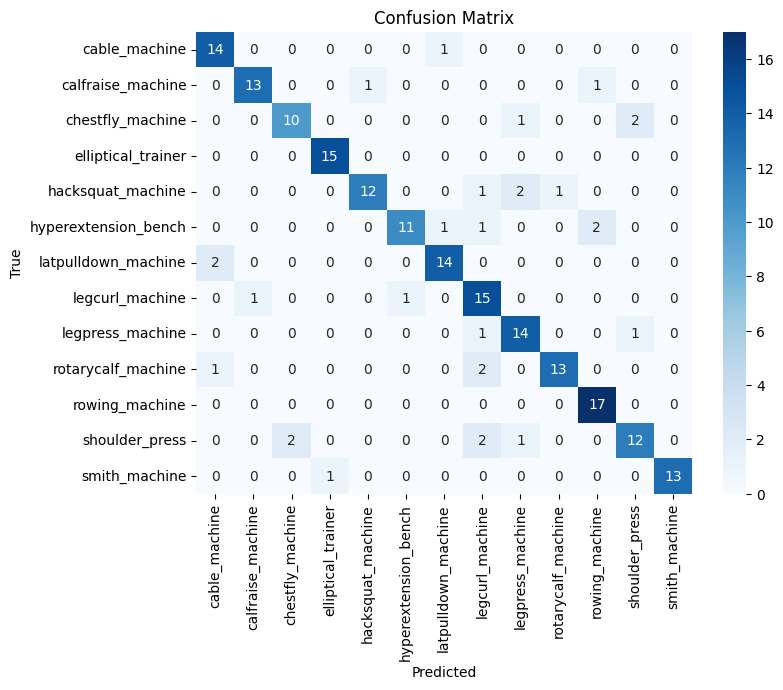

                      precision    recall  f1-score   support

       cable_machine       0.82      0.93      0.88        15
   calfraise_machine       0.93      0.87      0.90        15
    chestfly_machine       0.83      0.77      0.80        13
  elliptical_trainer       0.94      1.00      0.97        15
   hacksquat_machine       0.92      0.75      0.83        16
hyperextension_bench       0.92      0.73      0.81        15
 latpulldown_machine       0.88      0.88      0.88        16
     legcurl_machine       0.68      0.88      0.77        17
    legpress_machine       0.78      0.88      0.82        16
  rotarycalf_machine       0.93      0.81      0.87        16
      rowing_machine       0.85      1.00      0.92        17
      shoulder_press       0.80      0.71      0.75        17
       smith_machine       1.00      0.93      0.96        14

            accuracy                           0.86       202
           macro avg       0.87      0.86      0.86       202
      

In [19]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=categories))


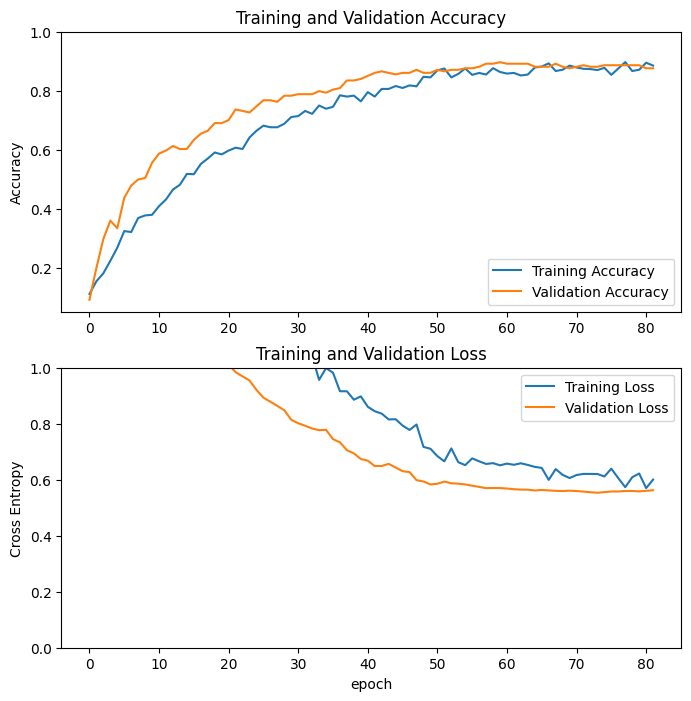

In [20]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Convert to tflite format

In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(history2.model)
tflite_model = converter.convert()

with open('mobnet_fine_tuned_model12.tflite', 'wb') as f:
    f.write(tflite_model)



INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmp54wcrpng\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmp54wcrpng\assets


## Load the tflite model to test with new image

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.applications.mobilenet import preprocess_input

interpreter = tf.lite.Interpreter(model_path="mobnet_fine_tuned_model12.tflite")
interpreter.allocate_tensors()

def load_and_preprocess_image(image_path, input_shape):
    image = Image.open(image_path).convert('RGB')
    image = image.resize((input_shape[1], input_shape[2]))
    image = np.array(image, dtype=np.float32)
    # image = ((image/255 - 0.5)/0.5)   # Normalize pixel values to [-1, 1]
    image = preprocess_input(image)
    # image = (image/255)
    # print(image)
    image = np.expand_dims(image, axis=0) 
    return image

image_path = 'smm.jpg'
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']
input_data = load_and_preprocess_image(image_path, input_shape)

interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])

predicted_class = np.argmax(output_data)

class_names = ['cable_machine', 'calfraise_machine', 'chestfly_machine', 'elliptical_trainer', 
               'hacksquat_machine', 'hyperextension_bench', 'latpulldown_machine', 'legcurl_machine', 
               'legpress_machine', 'rotarycalf_machine', 'rowing_machine', 'shoulder_press', 'smith_machine']

predicted_label = class_names[predicted_class]

print('Predicted class:', predicted_label)

image = Image.open(image_path)

plt.imshow(image)
plt.title('Predicted class: ' + predicted_label)
plt.axis("off")
plt.show()


### After training, we got 85% from test accuracy with no signs of overfitting
Trying and experiment on the hypermarameter to optimizing the model